https://khannay.github.io/posts/pytorch-ode/ode.html

In [2]:
%pip install torchdiffeq

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
import torch 
import torch.nn as nn
from torchdiffeq import odeint as odeint
import pylab as plt
from torch.utils.data import Dataset, DataLoader
from typing import Callable, List, Tuple, Union, Optional
from pathlib import Path 

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [14]:
from lv import LotkaVolterra

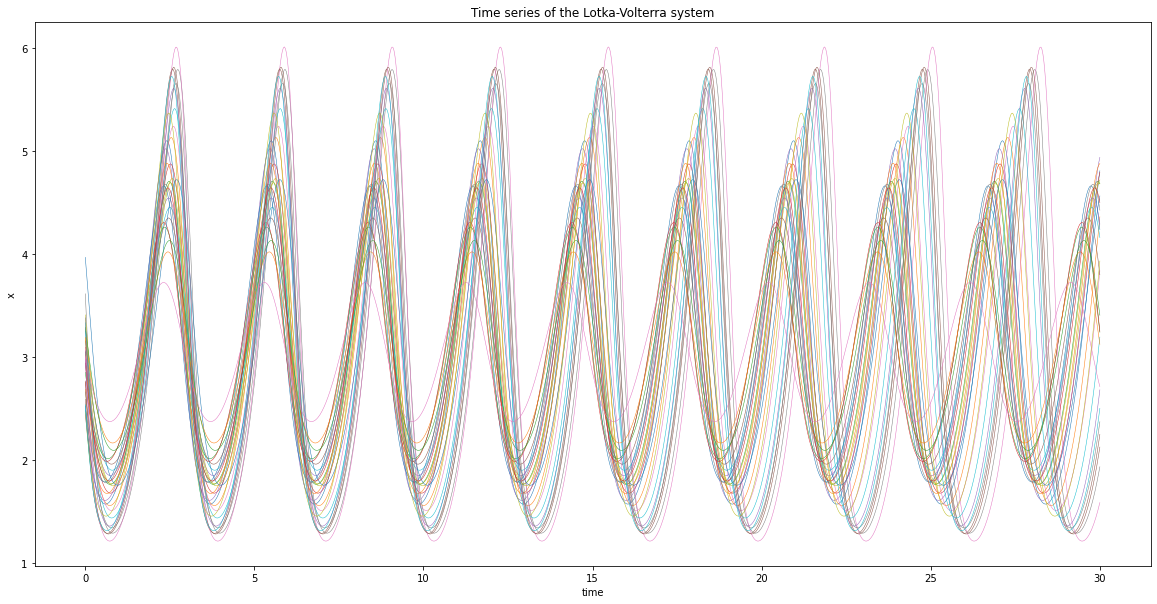

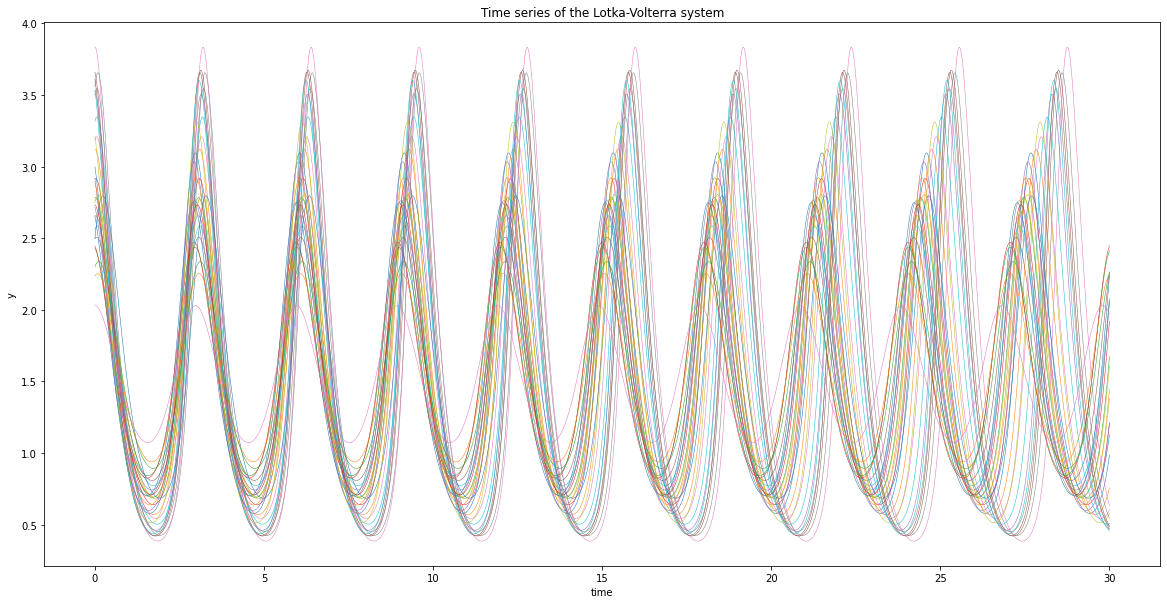

In [19]:
lv_model = LotkaVolterra() #use default parameters
ts = torch.linspace(0,30.0,1000) 
batch_size = 30
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[3,3]]) + 0.50*torch.randn((batch_size,2))
sol = odeint(lv_model, initial_conditions, ts, method='dopri5').detach().numpy()
# Check the solution

plt.figure(figsize=(20, 10))
plt.plot(ts, sol[:,:,0], lw=0.5);
plt.title("Time series of the Lotka-Volterra system");
plt.xlabel("time");
plt.ylabel("x");

plt.figure(figsize=(20, 10))
plt.plot(ts, sol[:,:,1], lw=0.5);
plt.title("Time series of the Lotka-Volterra system");
plt.xlabel("time");
plt.ylabel("y");

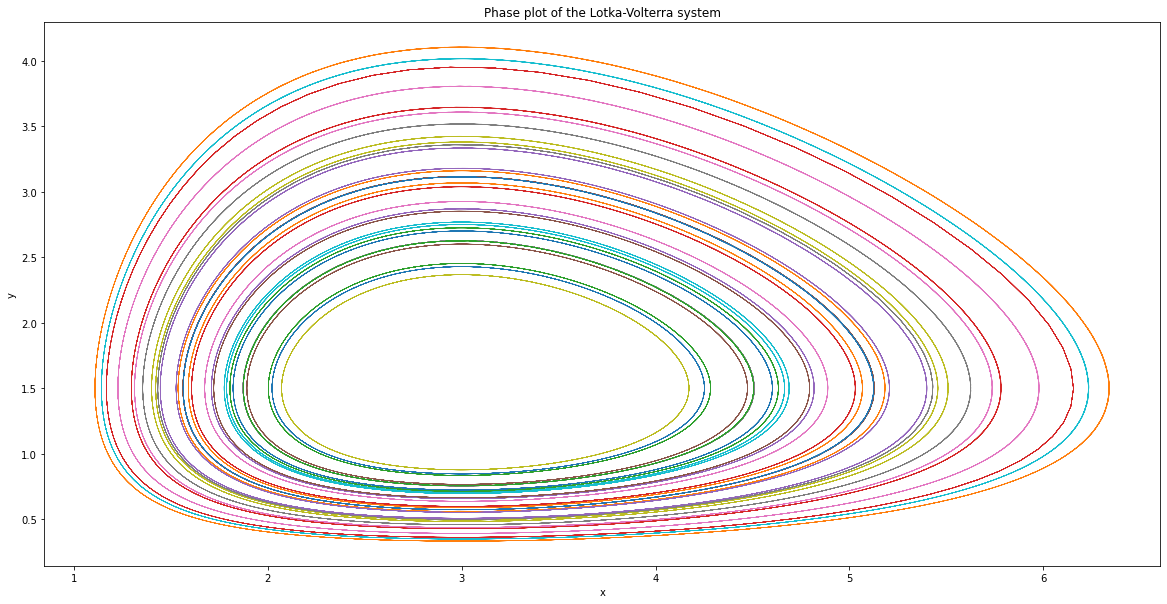

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(sol[:,:,0], sol[:,:,1], lw=0.5);
plt.title("Phase plot of the Lotka-Volterra system");
plt.xlabel("x");
plt.ylabel("y");

In [29]:
from data import SimODEData
from data import create_sim_dataset
from plot_model import plot_time_series
from plot_model import plot_phase_plane

In [30]:
def train(model: torch.nn.Module, # Model to train
          data: SimODEData, # Data to train on
          lr: float = 1e-2, # learning rate for the Adam optimizer
          epochs: int = 10, # Number of epochs to train for
          batch_size: int = 5, # Batch size for training
          method = 'rk4', # ODE solver to use
          step_size: float = 0.10, # for fixed diffeq solver set the step size
          show_every: int = 10, # How often to print the loss function message
          save_plots_every: Union[int,None] = None, # save a plot of the fit, to disable make this None
          model_name: str = "", #string for the model, used to reference the saved plots 
          *args: tuple, 
          **kwargs: dict
          ):
    
    # Create a data loader to iterate over the data. This takes in our dataset and returns batches of data
    trainloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    # Choose an optimizer. Adam is a good default choice as a fancy gradient descent
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Create a loss function this computes the error between the predicted and true values
    criterion = torch.nn.MSELoss() 
    
    for epoch in range(epochs):
        running_loss = 0.0 
        for batchdata in trainloader:
            optimizer.zero_grad() # reset gradients, famous gotcha in a pytorch training loop
            ts, states = batchdata # unpack the data 
            initial_state = states[:,0,:] # grab the initial state
            # Make the prediction and then flip the dimensions to be (batch, state_dim, time)
            # Pytorch expects the batch dimension to be first
            pred = odeint(model, initial_state, ts[0], method=method, options={'step_size': step_size}).transpose(0,1) 
            # Compute the loss
            loss = criterion(pred, states)
            # compute gradients
            loss.backward() 
            # update parameters
            optimizer.step() 
            running_loss += loss.item() # record loss
        if epoch % show_every == 0:
            print(f"Loss at {epoch}: {running_loss}")
        # Use this to save plots of the fit every save_plots_every epochs
        if save_plots_every is not None and epoch % save_plots_every == 0:
            with torch.no_grad():
                fig, ax = plot_time_series(data.true_model, model, data[0])
                ax.set_title(f"Epoch: {epoch}")
                fig.savefig(f"./tmp_plots/{epoch}_{model_name}_fit_plot")
                plt.close()

In [31]:
model_sim_lv = LotkaVolterra(1.5,1.0,3.0,1.0)
ts_data = torch.arange(0.0, 10.0, 0.1)
data_lv = create_sim_dataset(model_sim_lv, 
                              ts = ts_data, 
                              num_samples=10, 
                              sigma_noise=0.1,
                              initial_conditions_default=torch.tensor([2.5, 2.5]))

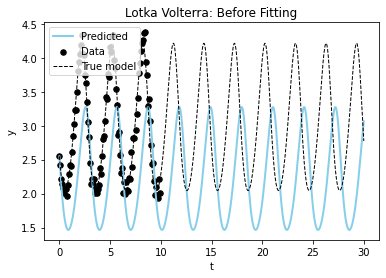

In [32]:
model_lv = LotkaVolterra(alpha=1.6, beta=1.1,delta=2.7, gamma=1.2) 

plot_time_series(model_sim_lv, model_lv, data = data_lv[0], title = "Lotka Volterra: Before Fitting");

In [33]:
train(model_lv, data_lv, epochs=60, lr=1e-2, model_name="lotkavolterra")
print(f"Fitted model: {model_lv}")
print(f"True model: {model_sim_lv}")

Loss at 0: 1.120684564113617
Loss at 10: 0.12688907980918884
Loss at 20: 0.0473667923361063
Loss at 30: 0.023348077200353146
Loss at 40: 0.021285006776452065
Loss at 50: 0.021102657541632652
Fitted model:  alpha: 1.5955464839935303,             beta: 1.048930048942566,                 delta: 2.818206787109375,                     gamma: 0.9389587044715881
True model:  alpha: 1.5,             beta: 1.0,                 delta: 3.0,                     gamma: 1.0


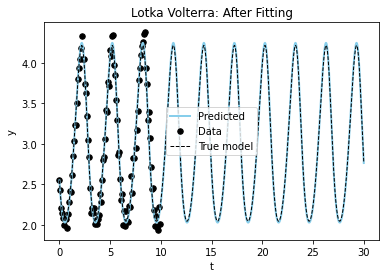

In [34]:
plot_time_series(model_sim_lv, model_lv, data = data_lv[0], title = "Lotka Volterra: After Fitting");

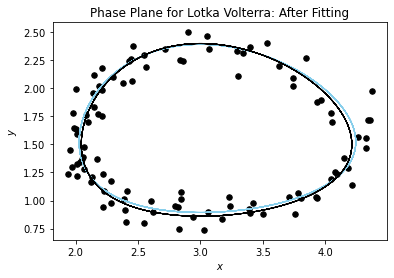

In [35]:
plot_phase_plane(model_sim_lv, model_lv, data_lv[0], title= "Phase Plane for Lotka Volterra: After Fitting");